In [100]:
import spacy
import numpy as np
import pandas as pd
import csv 
import sys
import os
import json
from collections import Counter

import lyricwikia

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib 

from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes()


PLAYLIST_DATASET_PATH = './../src/datasets/non_mpd_dataset/non_mpd_dataset.json'

LYRICS_PATH = './../src/datasets/non_mpd_dataset/lyrics'

SONGS_EMOTION_DF = './../src/datasets/non_mpd_emotions.csv'

emotion_labels = ['angry', 'happy','relaxed' ,'sad']

sys.path.append('./../src')

import song_featurize as sf
import playlist_classify as pc
import emoclassify

sf.set_lyrics_path(LYRICS_PATH)

In [101]:
df_schema = [ 'PID', 'angry', 'happy','relaxed' ,'sad' ]

In [102]:
# Thanks to https://gist.github.com/vladignatyev/06860ec2040cb497f0f3
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)

In [114]:
def plot_confusion_matrix(y_true, y_pred, title, labels, filename=None):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    df_cnf_matrix = pd.DataFrame(data=cnf_matrix)
    plt.figure(figsize = (8,6))
    #plt.title(title,fontsize=20)
    ax = sns.heatmap(df_cnf_matrix, annot=True, cmap='Blues',fmt='g',square=True,linewidths=.7, cbar_kws={"shrink": .5}, annot_kws={"size": 20})
    ax.set_xticklabels(labels,fontsize=20,  rotation=90)
    b = ax.set_yticklabels(labels,fontsize=20, rotation=360)
    if filename is not None:
        plt.savefig(filename)

# Dataset 

First of all we will load the dataset we obtain by manually annotating 40 playlists from Spotify.

In [9]:
f = open(PLAYLIST_DATASET_PATH, 'r')
dataset = json.load(f)
print('Number of playlists in the dataset:', len(dataset))

Number of playlists in the dataset: 40


Let's now have a look at how many songs each playlist has.

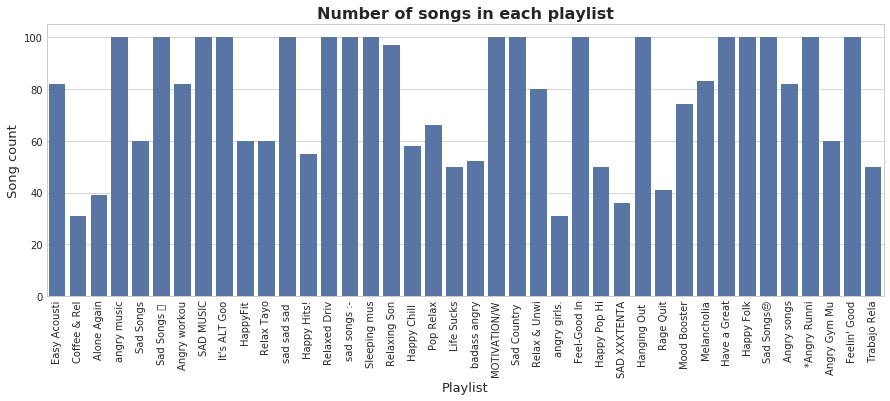

In [40]:
plt.figure(figsize=(15, 5))

count = [len(p['tracks']) for p in dataset]
ax = sns.barplot(x=np.array(range(len(count))),y=count, color='b', label='Song count in the playlist')
ax.set_title('Number of songs in each playlist', fontsize=16, fontweight='bold')
ax.set_xlabel('Playlist',fontsize=13)
ax.set_ylabel('Song count',fontsize=13)
ax.set_xticklabels([p['name'][:12] for p in dataset], rotation=90)
plt.show()

Let's now have a look at the class distribution.

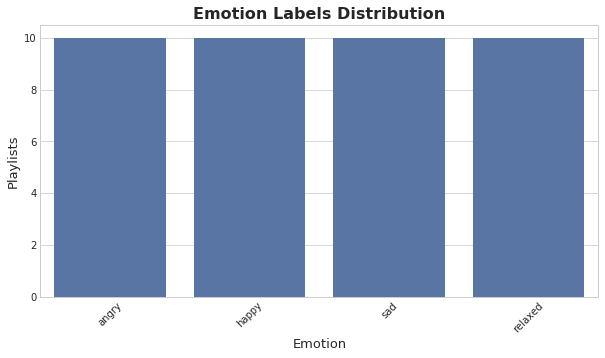

In [39]:
plt.figure(figsize=(10, 5))

emotion = [p['emotion'] for p in dataset]
emo_count = Counter(emotion)
ax = sns.barplot(x=np.array(range(4)), y=list(emo_count.values()), color='b', label='Song count in the playlist')
ax.set_title('Emotion Labels Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Emotion',fontsize=13)
ax.set_ylabel('Playlists',fontsize=13)
ax.set_xticklabels(list(emo_count.keys()), rotation=45)
plt.show()

# Songs Classification

First we need to download songs from LyricsWikia API. It may happen that we could be unable to download all of them.

In the next step we will also featurize each song we download and we will add it to a pandas dataframe to ease next analysis.

In [74]:
songs_list = [p['tracks'] for p in dataset]

In [77]:
def filename_from_song(seed, artist, title):
    f = '_'.join([str(seed), artist, title])
    f = f.replace('/', '-')
    return f

def store_file(content, path):
    with open(path, 'w') as sfile:
        sfile.write(content)

In [106]:
songs_count_after_download = list()

progress_count = 0
progress_total = len([item for sublist in songs_list for item in sublist])

df_rows = list()

for idx, s_list in enumerate(songs_list):
    count = 0
    for song in s_list:
        try: 
            lyric = lyricwikia.get_lyrics(song['artist'], song['title'])
            filename = filename_from_song(dataset[idx]['id'],
                                          song['artist'], 
                                          song['title'])
            store_file(lyric, os.path.join(LYRICS_PATH, filename))
            emotions = emoclassify.classify(filename, song['artist'], song['title'])
            df_rows.append([dataset[idx]['id']] + emotions)
            count += 1
        except lyricwikia.LyricsNotFound:
            errors += 1
        progress_count += 1
        progress(progress_count, progress_total, 'Downloading songs')
    songs_count_after_download.append(count)

songsDF = pd.DataFrame(df_rows, columns=df_schema)
    
print('Unable to download {} songs over'.format(errors, len(progress_total)))

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [ ]:
songsDF.to_csv(SONGS_EMOTION_DF)

In [ ]:
songsDF = pd.read_csv(SONGS_EMOTION_DF)

Let's now see how many songs we were unable to download.

In [ ]:
plt.figure(figsize=(15, 5))

count = [len(p['tracks']) for p in dataset]
ax = sns.barplot(x=np.array(range(len(count))),y=count, color='b', 
                 label='Song count in the playlist')
ax = sns.barplot(x=np.array(range(len(count))),y=songs_count_after_download, 
                 ax=ax, color='g', label='Downloaded songs')
plt.legend()
ax.set_title('Number of songs in each playlist', fontsize=16, fontweight='bold')
ax.set_xlabel('Playlist',fontsize=13)
ax.set_ylabel('Song count',fontsize=13)
ax.set_xticklabels([p['name'][:12] for p in dataset], rotation=90)
plt.show()

# Playlists Classification

Now we are ready to classify our playlists.

In [ ]:
map_mean = dict()
for emotion in emotion_labels:
    map_mean[emotion] = 'mean'
    
playlistsDF = songsDF.groupby(by='PID',as_index=False).agg(map_mean)

In [113]:
# Retrieve real emotion for each playlist
ids = [p['id'] for p in dataset]
emotions = [p['emotion'] for p in dataset]
y_true = emoclassify.encoder.transform(emotions)

emoDF = pd.DataFrame(list(zip(ids, emotions)), columns=['PID', 'emotion'])
emoDF.head()

,PID,emotion
0,46425,2
1,15705,2
2,29575,3
3,14510,0
4,40998,3


In [112]:
# Attach emotion to playlistsDF
playlistsDF = pd.merge(playlistsDF, emoDF, left_on=['PID'], right_on=[ 'PID'])
playlistsDF.head()

NameError: name 'playlistsDF' is not defined

In [ ]:
# Produce classification accuracy
y_pred = np.argmax(np.array([x[1:5] for x in playlistsDF.values]), axis=1)
print('Classification Accuracy: {}\%'.format(round(accuracy_score(y_true, y_pred) * 100,2)))

## Emotional Patterns in Playlists

## Analysis of misclassified playlists

Let's have a look at the confusion matrix of our classification results to understand where we are doing wrong.

In [ ]:
plot_confusion_matrix(y_true, y_pred, 
                      'Playlists Classification Confusion Matrix', 
                      emotion_labels)